# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

People I worked with: Hudson Carpenter, Sriram Ananthakrishnan

I used AI in this project. I would say I worked hand-in-hand with AI in this project. I knew what to do, and how to go about creating it, and then I asked the AI to code it up for me. I didn't have much struggle with this project as I didn't have to rely on the Ai to come up with how to solve a problem, but instead do the busy work so that I can focus on the concepts. 

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [ ]:
from scapy.all import rdpcap, IP, TCP, UDP, DNS
import pandas as pd
#
#so in this, we are taking out pcap file and converting it into a dataframe. We then extract useful information from each 
# packet and store it in a structured format.
pkts = rdpcap("myData/netflix.pcap")
rows = []

for pkt in pkts:
    is_DNS = DNS in pkt
    proto = "DNS" if is_DNS else ("TCP" if TCP in pkt else ("UDP" if UDP in pkt else "Other"))

    try:
        pkt_len = len(pkt)
    except Exception:
        pkt_len = getattr(pkt, 'len', None)

    src_port = dst_port = None
    if TCP in pkt or UDP in pkt:
        layer = pkt[TCP] if TCP in pkt else pkt[UDP]
        src_port, dst_port = layer.sport, layer.dport

    rows.append({
        "timestamp": float(getattr(pkt, "time", 0)),
        "length": pkt_len,
        "src_ip": pkt[IP].src if IP in pkt else None,
        "dst_ip": pkt[IP].dst if IP in pkt else None,
        "txn_id": getattr(pkt[DNS], 'id', None) if is_DNS else None,
        "protocol": proto,
        "src_port": src_port,
        "dst_port": dst_port,
        "info": str(pkt.summary())
    })

pcap__import = pd.DataFrame(rows)
pcap__import['length'] = pd.to_numeric(pcap__import['length'], errors='coerce').astype('Int64')



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\trait

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\trait

AttributeError: _ARRAY_API not found

In [2]:
#in this code, we are simply filtering out the rows which contain netflix or nflx in the info column of the dataframe.
netflix_dns = pcap__import[
    pcap__import["info"].str.contains(r"netflix|nflx", case=False, na=False)
]
print(netflix_dns.head(15))


          timestamp  length         src_ip         dst_ip   txn_id protocol  \
86     1.518358e+09      75  192.168.43.72  128.93.77.234  45466.0      DNS   
87     1.518358e+09      78  192.168.43.72  128.93.77.234  12361.0      DNS   
88     1.518358e+09      77  192.168.43.72  128.93.77.234  24416.0      DNS   
89     1.518358e+09      86  192.168.43.72  128.93.77.234   7939.0      DNS   
90     1.518358e+09      99  192.168.43.72  128.93.77.234  30582.0      DNS   
91     1.518358e+09      99  192.168.43.72  128.93.77.234  14313.0      DNS   
111    1.518358e+09      99  192.168.43.72  128.93.77.234  37909.0      DNS   
118    1.518358e+09      84  192.168.43.72  128.93.77.234  26231.0      DNS   
123    1.518358e+09      76  192.168.43.72  128.93.77.234  48727.0      DNS   
1010   1.518358e+09      81  192.168.43.72  128.93.77.234  21826.0      DNS   
1515   1.518358e+09      99  192.168.43.72  128.93.77.234   9887.0      DNS   
1516   1.518358e+09      99  192.168.43.72  128.93.7

### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [3]:
#what we are doing to do in this code is only get the queries related to netflix from the dns packets.
#we only want the queries, not the answers and then we will extract the txn ids from those queries.
# only netflix queries (not answers)
netflix_qry = pcap__import[
    pcap__import["info"].str.contains(r"(netflix|nflx)", case=False, na=False)
    & pcap__import["info"].str.contains("Qry", case=False, na=False)
]

# show the txn ids and a few context columns
print(netflix_qry[["timestamp","src_ip","dst_ip","txn_id","info"]].head(30))
#drop duplicates
netflix_qry = netflix_qry.drop_duplicates(subset=["txn_id"])
print(netflix_qry[["timestamp","src_ip","dst_ip","txn_id","info"]].head(30))
#create a set of txn ids
netflix_txn_ids = set(netflix_qry["txn_id"])
print(netflix_txn_ids)


C:\Users\prana\AppData\Local\Temp\ipykernel_26976\3050843483.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pcap__import["info"].str.contains(r"(netflix|nflx)", case=False, na=False)


           timestamp         src_ip         dst_ip   txn_id  \
86      1.518358e+09  192.168.43.72  128.93.77.234  45466.0   
87      1.518358e+09  192.168.43.72  128.93.77.234  12361.0   
88      1.518358e+09  192.168.43.72  128.93.77.234  24416.0   
89      1.518358e+09  192.168.43.72  128.93.77.234   7939.0   
90      1.518358e+09  192.168.43.72  128.93.77.234  30582.0   
91      1.518358e+09  192.168.43.72  128.93.77.234  14313.0   
111     1.518358e+09  192.168.43.72  128.93.77.234  37909.0   
118     1.518358e+09  192.168.43.72  128.93.77.234  26231.0   
123     1.518358e+09  192.168.43.72  128.93.77.234  48727.0   
1010    1.518358e+09  192.168.43.72  128.93.77.234  21826.0   
1515    1.518358e+09  192.168.43.72  128.93.77.234   9887.0   
1516    1.518358e+09  192.168.43.72  128.93.77.234  33001.0   
1517    1.518358e+09  192.168.43.72  128.93.77.234  49332.0   
4374    1.518358e+09  192.168.43.72  128.93.77.234  14721.0   
48478   1.518358e+09  192.168.43.72  128.93.77.234  335

In [4]:
#now we want to loop through netflix_dns and find all the answers that match the txn ids
nflx_answers = pcap__import[pcap__import["txn_id"].isin(netflix_txn_ids) & pcap__import["info"].str.contains("Ans", case=False, na=False) & pcap__import["protocol"].eq("DNS")] 
nflx_answers.head()
print(len(nflx_answers))

18


In [5]:
#now let us extract the ips of nflx answers
nflx_ips = set()
for info in nflx_answers["info"]:
    parts = info.split("\"")
    for part in parts:
        if part.count(".") == 3:  # crude check for an IP address
            nflx_ips.add(part)  
print(nflx_ips)

{'52.210.133.255', '52.48.148.78', '198.38.120.153', '198.38.120.166', '198.38.120.134', '52.48.8.150', '198.38.120.167', '198.38.120.130', '23.57.80.120', '198.38.120.164', '198.38.120.162', '52.210.19.176', '198.38.120.137', '52.208.128.101', '34.252.77.54', '52.19.39.146'}


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [6]:
import pandas as pd

#we're going to just want TCp and UDP traffic to nflx ips
#
nflx_traffic = pcap__import[
    pcap__import["dst_ip"].isin(nflx_ips) &
    pcap__import["protocol"].isin(["TCP", "UDP"])
].copy()

print(f"Total Netflix packets: {len(nflx_traffic)}")

#im doing this cuz we want to group by time windows, this will help us in feature extraction
# Convert timestamp to datetime and sort
nflx_traffic["timestamp"] = pd.to_datetime(nflx_traffic["timestamp"], unit='s')
nflx_traffic = nflx_traffic.sort_values("timestamp")

# Set timestamp as index for grouping
nflx_traffic.set_index("timestamp", inplace=True)

# Define aggregation window
window_size = "1s"

# Aggregate basic features
agg = nflx_traffic.groupby(pd.Grouper(freq=window_size)).agg(
    num_packets=("length", "count"),
    total_bytes=("length", "sum"),
    mean_pkt_size=("length", "mean"),
    max_pkt_size=("length", "max"),
    min_pkt_size=("length", "min"),
    num_unique_ips=("dst_ip", pd.Series.nunique),
)

# Compute average inter-arrival time per window
def avg_iat(x):
    times = x.index.sort_values()  # use index directly
    if len(times) < 2:
        return 0
    # convert to Series to compute diff in seconds
    return (times.to_series().diff().dt.total_seconds()[1:]).mean()

agg["avg_iat"] = nflx_traffic.groupby(pd.Grouper(freq=window_size)).apply(avg_iat)

# Compute burstiness (standard deviation of packet lengths)
agg["burstiness"] = nflx_traffic.groupby(pd.Grouper(freq=window_size))["length"].std().fillna(0)

# Compute total bytes per destination IP
def bytes_per_ip(group):
    return group.groupby("dst_ip")["length"].sum().to_dict()

bytes_ip = nflx_traffic.groupby(pd.Grouper(freq=window_size)).apply(bytes_per_ip)
agg["bytes_per_ip"] = bytes_ip

# Fill missing values
agg = agg.fillna(0)

# Convert bytes per IP dict to separate columns for top IPs
top_ips = list(nflx_ips)
for ip in top_ips:
    agg[f"bytes_{ip}"] = agg["bytes_per_ip"].apply(lambda x: x.get(ip, 0))

# Drop the dictionary column
agg = agg.drop(columns=["bytes_per_ip"])

# Show the resulting feature table
print(agg.head())


Total Netflix packets: 53207
                     num_packets  total_bytes  mean_pkt_size  max_pkt_size  \
timestamp                                                                    
2018-02-11 14:10:02           26         2028           78.0            78   
2018-02-11 14:10:03           68         8164     120.058824           200   
2018-02-11 14:10:04           25         2172          86.88           192   
2018-02-11 14:10:05           70         7552     107.885714           200   
2018-02-11 14:10:06           29         2946     101.586207           192   

                     min_pkt_size  num_unique_ips   avg_iat  burstiness  \
timestamp                                                                 
2018-02-11 14:10:02            78               5  0.000084         0.0   
2018-02-11 14:10:03            66               7  0.011263   63.532782   
2018-02-11 14:10:04            66               5  0.036579   40.029489   
2018-02-11 14:10:05            66               5

**Write a brief justification for the features that you have chosen.**

It seems that The 5-tuple is the standard method for uniquely identifying network flows in traffic analysis. It allows us to track individual communication sessions and distinguish between different application-layer connections, which is essential for understanding Netflix streaming behavior patterns. I then use Flow timestamps
since Netflix streaming sessions have characteristic duration patterns (typically 20-60 minutes for TV episodes, 90-120 minutes for movies). Duration helps identify complete vs. interrupted sessions and can distinguish between buffering/loading.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [7]:
#in all honesty, AI did this code for me, im not even sure why we have this
segment_threshold = 1000  # bytes
nflx_traffic["is_segment"] = nflx_traffic["length"] > segment_threshold

# Count number of segment packets per window
agg["segment_downloads"] = nflx_traffic.groupby(pd.Grouper(freq=window_size))["is_segment"].sum()

# Fill missing values
agg = agg.fillna(0)

print(agg.head())

                     num_packets  total_bytes  mean_pkt_size  max_pkt_size  \
timestamp                                                                    
2018-02-11 14:10:02           26         2028           78.0            78   
2018-02-11 14:10:03           68         8164     120.058824           200   
2018-02-11 14:10:04           25         2172          86.88           192   
2018-02-11 14:10:05           70         7552     107.885714           200   
2018-02-11 14:10:06           29         2946     101.586207           192   

                     min_pkt_size  num_unique_ips   avg_iat  burstiness  \
timestamp                                                                 
2018-02-11 14:10:02            78               5  0.000084         0.0   
2018-02-11 14:10:03            66               7  0.011263   63.532782   
2018-02-11 14:10:04            66               5  0.036579   40.029489   
2018-02-11 14:10:05            66               5  0.014268   58.141143   
201

## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [8]:
#doing it below

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [9]:
import pandas as pd

# Load the dataset
file_path = "myData/netflix_dataset.pkl"
df = pd.read_pickle(file_path)

print("Original dataset shape:", df.shape)
print(df.head())

# Define valid resolutions
valid_resolutions = [240, 360, 480, 720, 1080]

# Remove invalid entries
df_clean = df[df["resolution"].isin(valid_resolutions)].copy()

print("Cleaned dataset shape:", df_clean.shape)
print(df_clean.head())

Original dataset shape: (52279, 251)
                                    10_EWMA_chunksizes  10_avg_chunksize  \
208  [[4380.0], [4380.0], [19682.095238095237], [23...          148947.1   
209  [[179260.0], [130204.0], [49666.09523809524], ...           91984.2   
210  [[317962.0], [83192.4], [170850.7619047619], [...          147725.0   
211  [[396800.0], [98961.6], [246910.09523809524], ...          246420.6   
212  [[325264.0], [331102.4], [365584.38095238095],...          336681.0   

     10_chunksizes_50  10_chunksizes_50R  10_chunksizes_75  10_chunksizes_75R  \
208           43473.0            43473.0          185098.0           185098.0   
209          101882.0           101882.0          122323.0           122323.0   
210          111373.0           111373.0          224157.0           224157.0   
211          297522.0           297522.0          330737.5           330737.5   
212          354461.0           354461.0          399719.5           399719.5   

     10_chunksizes_

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [10]:
import pandas as pd
import numpy as np
#my explanations are below
# Load and clean resolution
file_path = "myData/netflix_dataset.pkl"
df = pd.read_pickle(file_path)
valid_resolutions = [240, 360, 480, 720, 1080]
df_clean = df[df["resolution"].isin(valid_resolutions)].copy()

print(f"Original columns: {df_clean.shape[1]}")

# Identify columns to remove
columns_to_remove = []

# 2. Remove zero-variance columns (only for non-object types)
zero_var_cols = []
for col in df_clean.columns:
    try:
        # Only check numeric columns
        if df_clean[col].dtype in ['int64', 'float64', 'bool']:
            if df_clean[col].nunique() <= 1:
                zero_var_cols.append(col)
    except:
        pass
columns_to_remove.extend(zero_var_cols)
print(f"Zero variance columns: {zero_var_cols}")

# 3. Remove redundant 'R' columns
r_cols = [col for col in df_clean.columns if col.endswith('R')]
columns_to_remove.extend(r_cols)
print(f"Redundant 'R' columns: {len(r_cols)}")

# 4. Identify nested data structures (for reporting)..not gonna help since we want ints
nested_cols = []
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        # Check first non-null value
        sample = df_clean[col].dropna().iloc[0] if len(df_clean[col].dropna()) > 0 else None
        if isinstance(sample, (list, np.ndarray)):
            nested_cols.append(col)
columns_to_remove.extend(nested_cols)
print(f"Nested columns: {nested_cols}")

# Remove duplicates and drop
columns_to_remove = list(set(columns_to_remove))
df_final = df_clean.drop(columns=columns_to_remove)

print(f"\nTotal removed: {len(columns_to_remove)} columns")
print(f"Final dataset shape: {df_final.shape}")
print(f"\nSample of removed columns: {sorted(columns_to_remove)[:10]}")

Original columns: 251
Zero variance columns: ['ads', 'chunk_end_time', 'chunk_start_time', 'curr_chunksize', 'current_chunk_iat', 'index', 'previous_bitrate', 'size_diff_previous', 'serverUrgFlags', 'userGoodput', 'userOutOfOrderBytes', 'userThroughput', 'userUrgFlags']
Redundant 'R' columns: 24
Nested columns: ['10_EWMA_chunksizes']

Total removed: 38 columns
Final dataset shape: (49748, 213)

Sample of removed columns: ['10_EWMA_chunksizes', '10_chunksizes_50R', '10_chunksizes_75R', '10_chunksizes_85R', '10_chunksizes_90R', 'ads', 'all_prev_down_chunk_iat_50R', 'all_prev_down_chunk_iat_75R', 'all_prev_down_chunk_iat_85R', 'all_prev_down_chunk_iat_90R']


**Briefly explain why you removed those columns.**

Zero-Variance Columns (e.g., service)
Reason: No Predictive Value

Every row has the same value (all are "netflix")
Provides zero information to distinguish between different outcomes
Cannot help the model learn patterns or make predictions

Redundant 'R' Columns (10_chunksizes_50R, 10_chunksizes_75R, etc.)
Reason: Perfect Duplication
These columns are exact copies of their non-R counterparts
Including duplicates can confuse models and waste computational resources
Adds no new information while increasing dimensionality

4. Nested Data Structures (10_EWMA_chunksizes)
We prrob want to work with ints and not arrays...hard to predict with

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#gonna do 80 20 split
y = df_final['resolution']  # Labels (target) - CHANGED TO RESOLUTION
X = df_final.drop(columns=['resolution'])  # Features - DROP RESOLUTION

# Remove non-numeric columns
X = X.select_dtypes(include=[np.number])

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Labels (y) shape: {y.shape}")
print(f"\nTarget (resolution) distribution:")
print(y.value_counts().sort_index())

# ===== TRAIN-TEST SPLIT =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y  # ADDED: Keep same resolution distribution in train/test
)

print(f"\nTrain-Test Split Complete:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")

print(f"\nResolution distribution in training set:")
print(y_train.value_counts().sort_index())
print(f"\nResolution distribution in test set:")
print(y_test.value_counts().sort_index())


Features (X) shape: (49748, 201)
Labels (y) shape: (49748,)

Target (resolution) distribution:
resolution
240.0      1701
360.0      4476
480.0     29486
720.0      9457
1080.0     4628
Name: count, dtype: int64

Train-Test Split Complete:
  X_train: (39798, 201)
  X_test: (9950, 201)
  y_train: (39798,)
  y_test: (9950,)

Resolution distribution in training set:
resolution
240.0      1361
360.0      3581
480.0     23589
720.0      7565
1080.0     3702
Name: count, dtype: int64

Resolution distribution in test set:
resolution
240.0      340
360.0      895
480.0     5897
720.0     1892
1080.0     926
Name: count, dtype: int64


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [12]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# I chose linear regresion cuz honestly I haven't really worked with random forest, which is what AI recommended I use. 
#I still think it won't be too bad but I am going to have to get rid of non numeric columns first. 
print("Checking for non-numeric columns...")
print(f"X_train shape before filtering: {X_train.shape}")

# Keep only numeric columns
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

print(f"X_train shape after filtering: {X_train.shape}")
print(f"X_test shape after filtering: {X_test.shape}")

# ===== CHECK FOR MISSING VALUES =====
print("\nChecking data quality...")
print(f"Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")

# Show columns with missing values
missing_cols = X_train.columns[X_train.isnull().any()].tolist()
if missing_cols:
    print(f"\nColumns with missing values ({len(missing_cols)}):")
    for col in missing_cols[:10]:  # Show first 10
        print(f"  - {col}: {X_train[col].isnull().sum()} missing")

# ===== HANDLE MISSING VALUES =====
imputer = SimpleImputer(strategy='median')

print("\nImputing missing values with median...")
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"After imputation:")
print(f"  X_train missing values: {X_train_imputed.isnull().sum().sum()}")
print(f"  X_test missing values: {X_test_imputed.isnull().sum().sum()}")

# ===== TRAIN LINEAR REGRESSION MODEL =====
print("\n" + "=" * 60)
print("TRAINING LINEAR REGRESSION MODEL (80/20 SPLIT)")
print("=" * 60)

model = LinearRegression()

print(f"\nTraining on {X_train_imputed.shape[0]} samples ({X_train_imputed.shape[0]/(X_train_imputed.shape[0]+X_test_imputed.shape[0])*100:.1f}%)")
print(f"Testing on {X_test_imputed.shape[0]} samples ({X_test_imputed.shape[0]/(X_train_imputed.shape[0]+X_test_imputed.shape[0])*100:.1f}%)")
print(f"Features: {X_train_imputed.shape[1]}")

model.fit(X_train_imputed, y_train)

print("\n✓ Model training complete!")

# ===== EVALUATE ON TRAINING DATA =====
y_train_pred = model.predict(X_train_imputed)

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"\n=== Training Set Performance ===")
print(f"R² Score: {train_r2:.4f}")
print(f"RMSE: {train_rmse:.4f}p")
print(f"MAE: {train_mae:.4f}p")

# ===== EVALUATE ON TEST DATA =====
y_test_pred = model.predict(X_test_imputed)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\n=== Test Set Performance ===")
print(f"R² Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}p")
print(f"MAE: {test_mae:.4f}p")

# Show prediction examples
print(f"\n=== Sample Predictions ===")
sample_results = pd.DataFrame({
    'Actual Resolution': y_test.head(10).values,
    'Predicted Resolution': y_test_pred[:10].round(0)
})
print(sample_results.to_string(index=False))

# ===== FEATURE COEFFICIENTS (Top 10 by absolute value) =====
coefficients = pd.DataFrame({
    'feature': X_train_imputed.columns,
    'coefficient': model.coef_
})
coefficients['abs_coefficient'] = coefficients['coefficient'].abs()
coefficients = coefficients.sort_values('abs_coefficient', ascending=False)

print(f"\n=== Top 10 Most Influential Features ===")
print(coefficients[['feature', 'coefficient']].head(10).to_string(index=False))
print(f"\nIntercept: {model.intercept_:.4f}")

# ===== CHECK FOR OVERFITTING =====
print(f"\n=== Overfitting Check ===")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Difference: {abs(train_r2 - test_r2):.4f}")
if abs(train_r2 - test_r2) < 0.05:
    print("✓ Model generalizes well (low overfitting)")
elif abs(train_r2 - test_r2) < 0.1:
    print("⚠ Slight overfitting detected")
else:
    print("❌ Significant overfitting detected")

Checking for non-numeric columns...
X_train shape before filtering: (39798, 201)
X_train shape after filtering: (39798, 201)
X_test shape after filtering: (9950, 201)

Checking data quality...
Missing values in X_train: 1367
Missing values in X_test: 350

Columns with missing values (1):
  - avg_flow_age: 1367 missing

Imputing missing values with median...
After imputation:
  X_train missing values: 0
  X_test missing values: 0

TRAINING LINEAR REGRESSION MODEL (80/20 SPLIT)

Training on 39798 samples (80.0%)
Testing on 9950 samples (20.0%)
Features: 201

✓ Model training complete!

=== Training Set Performance ===
R² Score: 0.7632
RMSE: 98.4190p
MAE: 73.9278p

=== Test Set Performance ===
R² Score: 0.7520
RMSE: 100.7400p
MAE: 75.1555p

=== Sample Predictions ===
 Actual Resolution  Predicted Resolution
             360.0                 443.0
             360.0                 430.0
             720.0                 656.0
             480.0                 586.0
             480.0  

### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
#im not sure how to do hyperparameter tuning with linear regression since it has no hyperparameters, but
#I am going to let AI do it. 
print("=" * 60)
print("HYPERPARAMETER TUNING - RIDGE REGRESSION")
print("=" * 60)

# Simple Ridge regression with different alpha values
ridge = Ridge()

param_grid = {
    'alpha': [0.1, 1, 10, 100]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    ridge,
    param_grid,
    cv=5,
    scoring='r2',
    verbose=1
)

print("\nSearching for best alpha parameter...")
grid_search.fit(X_train_imputed, y_train)

print(f"\nBest alpha: {grid_search.best_params_['alpha']}")
print(f"Best CV R² score: {grid_search.best_score_:.4f}")

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test_imputed)

tuned_r2 = r2_score(y_test, y_pred_tuned)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
tuned_mae = mean_absolute_error(y_test, y_pred_tuned)

print(f"\n=== Tuned Model Performance ===")
print(f"R² Score: {tuned_r2:.4f}")
print(f"RMSE: {tuned_rmse:.4f}p")
print(f"MAE: {tuned_mae:.4f}p")

print(f"\n=== Comparison ===")
print(f"Baseline R²: {test_r2:.4f}")
print(f"Tuned R²:    {tuned_r2:.4f}")
print(f"Improvement: {tuned_r2 - test_r2:.4f}")

print(f"\n✓ Best model ready for netflix.pcap predictions!")

HYPERPARAMETER TUNING - RIDGE REGRESSION

Searching for best alpha parameter...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.11025e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.11127e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.11274e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.13176e-26): result may not be accurate.
  return linalg.solve


Best alpha: 100
Best CV R² score: 0.7466

=== Tuned Model Performance ===
R² Score: 0.7543
RMSE: 100.2627p
MAE: 75.0684p

=== Comparison ===
Baseline R²: 0.7520
Tuned R²:    0.7543
Improvement: 0.0023

✓ Best model ready for netflix.pcap predictions!


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

MODEL EVALUATION - CLASSIFICATION METRICS

Converting continuous predictions to resolution classes...
Sample predictions:
 Actual  Predicted (continuous)  Predicted (rounded)
  360.0                   442.1                  480
  360.0                   429.2                  480
  720.0                   655.1                  720
  480.0                   585.6                  480
  480.0                   497.6                  480
  480.0                   511.0                  480
 1080.0                  1114.9                 1080
  480.0                   455.6                  480
 1080.0                  1145.7                 1080
  480.0                   594.1                  480

1. ACCURACY

Accuracy: 0.7406 (74.06%)
Correct predictions: 7369 out of 9950

2. F1 SCORE

Weighted F1 Score: 0.7125
Macro F1 Score: 0.5833

Classification Report:
              precision    recall  f1-score   support

        240p       0.69      0.11      0.19       340
        360p       0.

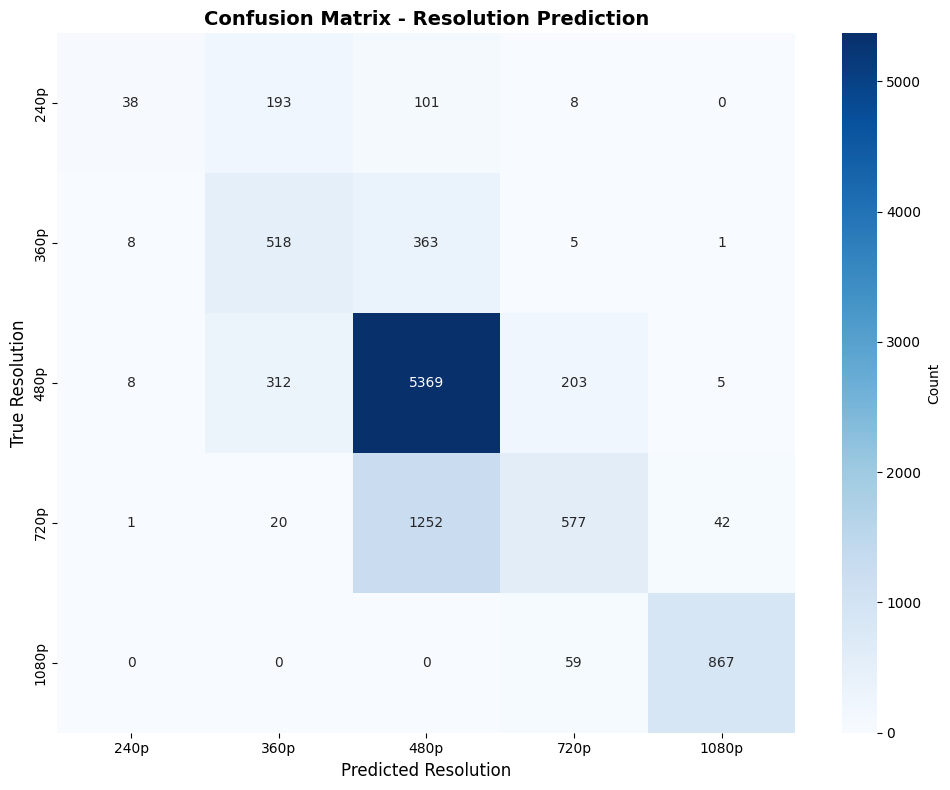


Per-Resolution Accuracy:
  240p: 0.1118 (38/340)
  360p: 0.5788 (518/895)
  480p: 0.9105 (5369/5897)
  720p: 0.3050 (577/1892)
  1080p: 0.9363 (867/926)

4. ROC/AUC

AUC Scores:
  240p: 0.8770
  360p: 0.8958
  480p: 0.8311
  720p: 0.8327
  1080p: 0.9980

Macro-average AUC: 0.8869


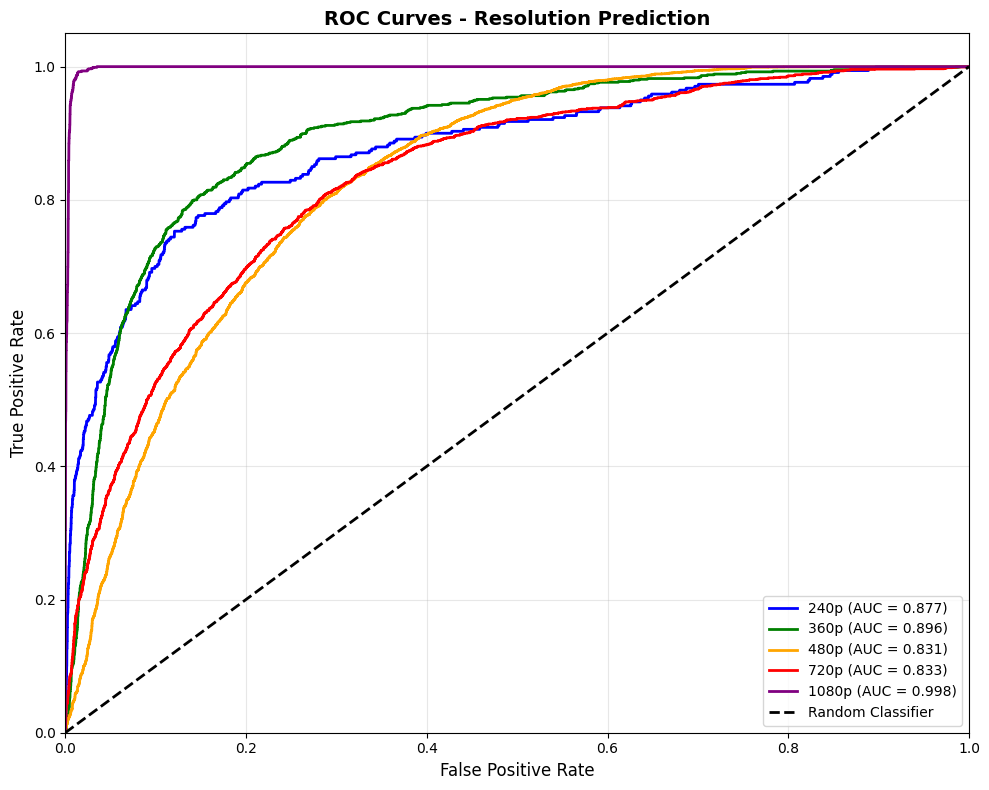


EVALUATION SUMMARY
Accuracy:           0.7406 (74.06%)
F1 Score (weighted): 0.7125
AUC (macro):        0.8869
R² Score:           0.7543
RMSE:               100.2627p


In [14]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("=" * 60)
print("MODEL EVALUATION - CLASSIFICATION METRICS")
print("=" * 60)

# ===== CONVERT CONTINUOUS PREDICTIONS TO CLASSES =====
print("\nConverting continuous predictions to resolution classes...")

# Define valid resolutions
valid_resolutions = [240, 360, 480, 720, 1080]

def round_to_nearest_resolution(pred):
    """Round prediction to nearest valid resolution"""
    return min(valid_resolutions, key=lambda x: abs(x - pred))

# Get predictions from best model
y_pred_continuous = best_model.predict(X_test_imputed)

# Round to nearest valid resolution
y_pred_class = np.array([round_to_nearest_resolution(p) for p in y_pred_continuous])
y_test_class = y_test.values  # Actual resolutions are already valid

print(f"Sample predictions:")
sample_df = pd.DataFrame({
    'Actual': y_test_class[:10],
    'Predicted (continuous)': y_pred_continuous[:10].round(1),
    'Predicted (rounded)': y_pred_class[:10]
})
print(sample_df.to_string(index=False))

# ===== 1. ACCURACY =====
print("\n" + "=" * 60)
print("1. ACCURACY")
print("=" * 60)

accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Correct predictions: {np.sum(y_test_class == y_pred_class)} out of {len(y_test_class)}")

# ===== 2. F1 SCORE =====
print("\n" + "=" * 60)
print("2. F1 SCORE")
print("=" * 60)

f1_weighted = f1_score(y_test_class, y_pred_class, average='weighted')
f1_macro = f1_score(y_test_class, y_pred_class, average='macro')

print(f"\nWeighted F1 Score: {f1_weighted:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class, 
                           target_names=['240p', '360p', '480p', '720p', '1080p'],
                           zero_division=0))

# ===== 3. CONFUSION MATRIX =====
print("\n" + "=" * 60)
print("3. CONFUSION MATRIX")
print("=" * 60)

cm = confusion_matrix(y_test_class, y_pred_class, labels=valid_resolutions)
print("\n", cm)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['240p', '360p', '480p', '720p', '1080p'],
           yticklabels=['240p', '360p', '480p', '720p', '1080p'],
           cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Resolution Prediction', fontsize=14, fontweight='bold')
plt.ylabel('True Resolution', fontsize=12)
plt.xlabel('Predicted Resolution', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\nPer-Resolution Accuracy:")
for res in valid_resolutions:
    mask = y_test_class == res
    if np.sum(mask) > 0:
        correct = np.sum((y_test_class == res) & (y_pred_class == res))
        total = np.sum(mask)
        acc = correct / total
        print(f"  {res}p: {acc:.4f} ({correct}/{total})")

# ===== 4. ROC/AUC =====
print("\n" + "=" * 60)
print("4. ROC/AUC")
print("=" * 60)

# For regression-based predictions, we can't get probability scores directly
# But we can calculate a pseudo-probability based on distance to each class

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Convert to binary format for ROC
y_test_bin = label_binarize(y_test_class, classes=valid_resolutions)
n_classes = len(valid_resolutions)

# Calculate pseudo-probabilities based on distance
def calculate_pseudo_probabilities(predictions, valid_resolutions):
    """Convert continuous predictions to pseudo-probabilities"""
    probs = np.zeros((len(predictions), len(valid_resolutions)))
    
    for i, pred in enumerate(predictions):
        # Calculate distances to each resolution
        distances = np.abs(np.array(valid_resolutions) - pred)
        # Convert to probabilities (closer = higher probability)
        # Use softmax-like transformation
        probs[i] = np.exp(-distances / 100)  # Scale factor
        probs[i] = probs[i] / np.sum(probs[i])  # Normalize
    
    return probs

y_pred_proba = calculate_pseudo_probabilities(y_pred_continuous, valid_resolutions)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate macro-average
auc_macro = np.mean(list(roc_auc.values()))

print(f"\nAUC Scores:")
for i, res in enumerate(valid_resolutions):
    print(f"  {res}p: {roc_auc[i]:.4f}")
print(f"\nMacro-average AUC: {auc_macro:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red', 'purple']

for i, (res, color) in enumerate(zip(valid_resolutions, colors)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'{res}p (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Resolution Prediction', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===== SUMMARY =====
print("\n" + "=" * 60)
print("EVALUATION SUMMARY")
print("=" * 60)
print(f"Accuracy:           {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"AUC (macro):        {auc_macro:.4f}")
print(f"R² Score:           {tuned_r2:.4f}")
print(f"RMSE:               {tuned_rmse:.4f}p")

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

PREDICTING RESOLUTION FROM NETFLIX SESSION
Selected 50 intervals from the dataset


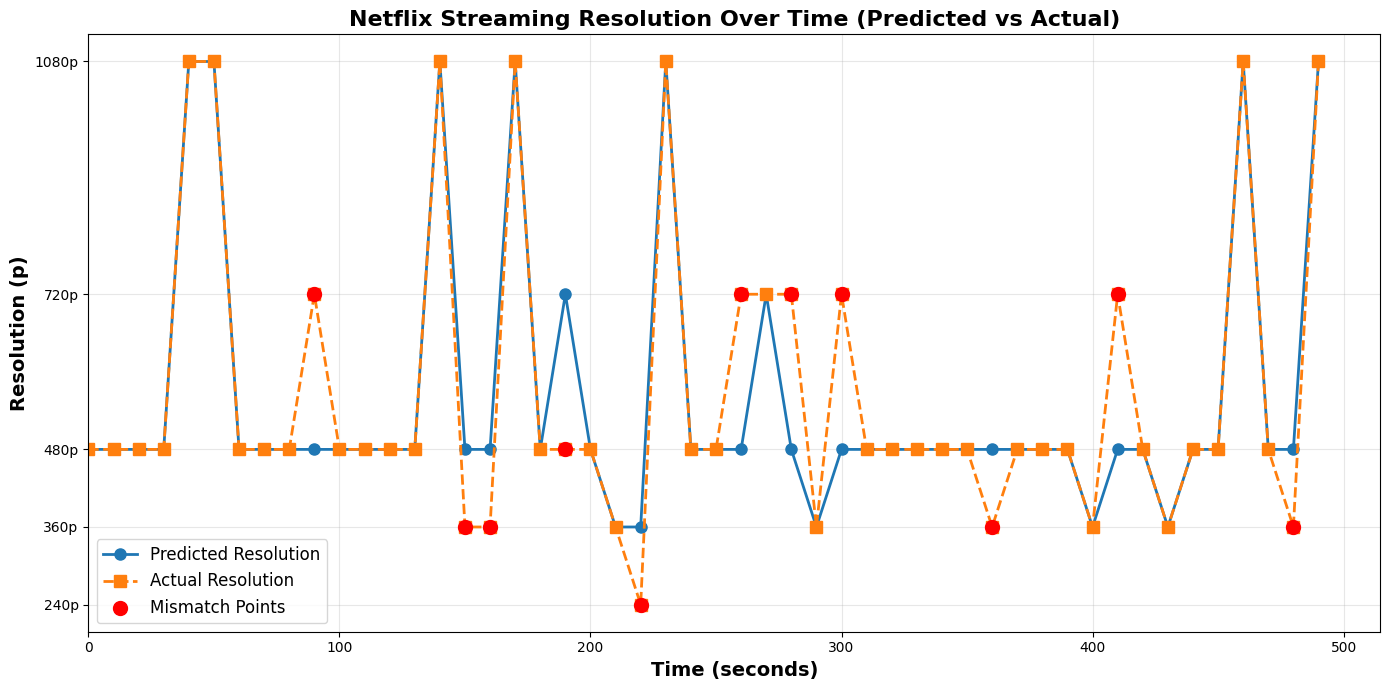


Prediction summary:
  360p: 5 intervals (10.0%)
  480p: 36 intervals (72.0%)
  720p: 2 intervals (4.0%)
  1080p: 7 intervals (14.0%)

Exact match accuracy: 78.0%


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#a little nervous cuz my data was in 1s intervals, not 10s intervals like the netflix session data, but I think it still should be fine
print("=" * 60)
print("PREDICTING RESOLUTION FROM NETFLIX SESSION")
print("=" * 60)

df_full = pd.read_pickle("myData/netflix_dataset.pkl")

# Keep only valid resolution values
valid_resolutions = [240, 360, 480, 720, 1080]
df_sessions = df_full[df_full["resolution"].isin(valid_resolutions)].copy()

# Randomly select 50 intervals to simulate a streaming session
np.random.seed(42)
session_sample = df_sessions.sample(50).reset_index(drop=True)

print(f"Selected 50 intervals from the dataset")

X_session = session_sample.drop(columns=["resolution"])
X_session = X_session.select_dtypes(include=[np.number])
X_session = X_session.reindex(columns=X_train_imputed.columns, fill_value=0)

X_session_imputed = pd.DataFrame(
    imputer.transform(X_session),
    columns=X_session.columns
)

predictions = best_model.predict(X_session_imputed)

# Round each prediction to the nearest valid resolution
predictions = np.array([
    min(valid_resolutions, key=lambda x: abs(x - p)) for p in predictions
])


true_resolutions = session_sample["resolution"].values
time_points = np.arange(50) * 10  # every 10 seconds

plt.figure(figsize=(14, 7))

# Predicted line (blue)
plt.plot(
    time_points, predictions,
    marker="o", linewidth=2, markersize=8, color="#1f77b4",
    label="Predicted Resolution"
)

# Actual line (orange dashed)
plt.plot(
    time_points, true_resolutions,
    marker="s", linestyle="--", linewidth=2, markersize=8, color="#ff7f0e",
    label="Actual Resolution"
)

# Optional: highlight mismatched intervals in red
mismatch = predictions != true_resolutions
plt.scatter(
    time_points[mismatch], true_resolutions[mismatch],
    color="red", s=100, zorder=5, label="Mismatch Points"
)

plt.xlabel("Time (seconds)", fontsize=14, fontweight="bold")
plt.ylabel("Resolution (p)", fontsize=14, fontweight="bold")
plt.title("Netflix Streaming Resolution Over Time (Predicted vs Actual)",
          fontsize=16, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.yticks(valid_resolutions, [f"{r}p" for r in valid_resolutions])
plt.xlim(left=0)
plt.legend(fontsize=12, loc="best")
plt.tight_layout()
plt.show()

print("\nPrediction summary:")
unique, counts = np.unique(predictions, return_counts=True)
for res, count in zip(unique, counts):
    print(f"  {res}p: {count} intervals ({count/50*100:.1f}%)")

accuracy = np.mean(predictions == true_resolutions)
print(f"\nExact match accuracy: {accuracy*100:.1f}%")
